**INTRODUCTION**

As a deep learning lover, I always used libraries like Keras to build deep neural networks.
But recently, I was looking to [this](https://www.kaggle.com/kanncaa1/deep-learning-tutorial-for-beginners) kernel provided by DATAI and thinking about improving the Artificial Neural Network part to make it more customizable.

On this Kernel you will find a simple, primitive approach to make a deep neural network :) Have a fun reading.

**DATA PREPROCESS**

In [1]:
### importing some libraries

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt  # data visualizations
from sklearn.preprocessing import LabelEncoder  # label encoder
from sklearn.model_selection import train_test_split  # Splitter

### Working on te Data ###

df = pd.read_csv("../input/mushrooms.csv") # reading

label_encoder = LabelEncoder()  
df = df.apply(label_encoder.fit_transform) # label encoding

#

y = df["class"].values   # our labels.. okay to eat or poison.

df.drop(["class"],axis=1,inplace=True)  # dropping the lables from the data
df.drop(["veil-color"],axis=1,inplace=True)
df.drop(["veil-type"],axis=1,inplace=True)

x_data = df  # our features..
x = (x_data - np.min(x_data))/(np.max(x_data)-np.min(x_data)).values # normalization

#

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)   # 20% would be enough

x_train = x_train.values.T
x_test = x_test.values.T

y_train = y_train.reshape(-1,1).T
y_test = y_test.reshape(-1,1).T

**THIS IS WHERE REAL STUFF STARTS**

In [2]:
def initialize_param(layers_with_nodes,in_data,out_data):
    
    # we start with initializing the input layer's values.
    
    layer_amount = len(layers_with_nodes)
    
    parameters = {}
    parameters["weight1"] = np.random.randn(layers_with_nodes[0],in_data.shape[0]) * 0.1
    parameters["bias1"] = np.zeros((layers_with_nodes[0],1))
    
    print("" + str(layer_amount+2) + " layers. (" + str(layer_amount) + " hidden layer)")

    # then we initialize the hidden layer's values.
    
    for i in range(layer_amount-1):
        #print(i+2)
        w = "weight" + str(i+2)
        b = "bias" + str(i+2)
        parameters[w] = np.random.randn(layers_with_nodes[i+1],layers_with_nodes[i]) * 0.1
        parameters[b] = np.zeros((layers_with_nodes[i+1],1))
    
    # and lastly output layer's values.
    
    lastw = "weight" + str(layer_amount+1)
    lastb = "bias" + str(layer_amount+1)
    parameters[lastw] = np.random.randn(out_data.shape[0],layers_with_nodes[layer_amount-1]) * 0.1
    parameters[lastb] = np.zeros((out_data.shape[0],1))
    
    return parameters, (layer_amount+1)

In [3]:
def sigmoid(x):
    y_head = 1/(1 + np.exp(-x))   # basic sigmoid for output layer
    return y_head;

def compute_cost(A_f, y_train):
    logprobs = np.multiply(np.log(A_f),y_train)
    cost = -np.sum(logprobs)/y_train.shape[1]    # computing the loss value, so we can improve our success more in the future.
    return cost

In [4]:
def forw_prop_NN(in_data, parameters, connection_amount):
    
    cache = {}
    a0 = in_data
    
    # forward propagation until last layer is same because we use tanh for all except output layer.
    
    for i in range(connection_amount-1):
        w = "weight" + str(i+1)   
        b = "bias" + str(i+1) 
        
        z = "Z" + str(i+1)
        a = "A" + str(i+1)
        
        cache[z] = np.dot(parameters[w],a0) + parameters[b]
        cache[a] = np.tanh(cache[z])
        a0 = cache[a]
        
        
    # then on the output(last) layer we use sigmoid.
    
    z_fin = "Z" + str(connection_amount)
    a_fin = "A" + str(connection_amount)
    
    w = "weight" + str(connection_amount)   
    b = "bias" + str(connection_amount)
    
    a0 = "A" + str(connection_amount-1)
    
    cache[z_fin] = np.dot(parameters[w],cache[a0]) + parameters[b]
    cache[a_fin] = sigmoid(cache[z_fin])
    A = cache[a_fin]
    
    return A, cache
        

In [5]:
def backw_prop_NN(parameters,cache,x_train,y_train,connection_amount):
    
    dz = {}
    grads = {}
    
    # since we are going backwards on back propagation, we update values from last to first
    # so firstly we will start with output layer.
    
    a_fin = "A" + str(connection_amount)
    a_pre_fin = "A" + str(connection_amount-1)
    w_fin = "dweight" + str(connection_amount)
    b_fin = "dbias" + str(connection_amount)
    
    dz[connection_amount] = cache[a_fin] - y_train
    grads[w_fin] = np.dot(dz[connection_amount],cache[a_pre_fin].T)/x_train.shape[1]
    grads[b_fin] = np.sum(dz[connection_amount], axis=1, keepdims=True)/x_train.shape[1]
    
    # then continue with the rest of layers.
    
    for i in range((connection_amount-1),1,-1):
        a = "A" + str(i)
        a_pre = "A" + str(i-1)
        dw = "dweight" + str(i)
        db = "dbias" + str(i)
        w = "weight" + str(i+1)
        
        dz[i] = np.dot(parameters[w].T,dz[i+1])*(1 - np.power(cache[a], 2))
        grads[dw] = np.dot(dz[i],cache[a_pre].T)/x_train.shape[1]
        grads[db] = np.sum(dz[i], axis=1,keepdims=True)/x_train.shape[1]
    
    dz[1] = np.dot(parameters["weight2"].T,dz[2])*(1 - np.power(cache["A1"], 2))
    grads["dweight1"] = np.dot(dz[1],x_train.T)/x_train.shape[1]
    grads["dbias1"] = np.sum(dz[1],axis =1,keepdims=True)/x_train.shape[1]
    
    return grads

In [6]:
def update_param(parameters, grads, connection_amount, lr=0.01):
    for i in range(connection_amount):
        w = "weight" + str(i+1)
        b = "bias" + str(i+1)
        dw = "dweight" + str(i+1)
        db = "dbias" + str(i+1)
        
        parameters[w] = parameters[w] - lr*grads[dw]
        parameters[b] = parameters[b] - lr*grads[db]
        
    return parameters                 # basic update for all layers...

In [7]:
def predict(A,parameters,x_test,connection_amount):
    # x_test is a input for forward propagation
    A, cache = forw_prop_NN(x_test,parameters,connection_amount)
    Y_prediction = np.zeros((1,x_test.shape[1]))
 
    for i in range(A.shape[1]):
        if A[0,i]<= 0.5:
            Y_prediction[0,i] = 0
        else:
            Y_prediction[0,i] = 1

    return Y_prediction             # basic binary prediction...

In [8]:
def multi_layer_model(layers_with_nodes,x_train,y_train,x_test,y_test, num_iter, lr = 0.01):    # only learning rate is pre-defined
    
    cost_list = []     
    index_list = []
    
    parameters, connection_amount = initialize_param(layers_with_nodes, x_train, y_train)   # starting with initializing for only once
    
    # then do the following part for each iteration..
    
    for i in range(0, num_iter):
         # forward propagation
        A, cache = forw_prop_NN(x_train,parameters,connection_amount)
        # compute cost
        cost = compute_cost(A, y_train)
         # backward propagation
        grads = backw_prop_NN(parameters,cache,x_train,y_train,connection_amount)
         # update parameters
        parameters = update_param(parameters, grads, connection_amount, lr)
        
        if i % 100 == 0:
            cost_list.append(cost)
            index_list.append(i)
            print ("Cost after iteration %i: %f" %(i, cost))

    plt.plot(index_list,cost_list)
    plt.xticks(index_list,rotation='vertical')
    plt.xlabel("Number of Iterarion")
    plt.ylabel("Cost")
    plt.show()
    
    # predict
   
    y_prediction_train = predict(A, parameters, x_train, connection_amount)
    y_prediction_test = predict(A, parameters, x_test, connection_amount)

    # Print train/test Errors
    print("train accuracy: {} %".format(100 - np.mean(np.abs(y_prediction_train - y_train)) * 100))
    print("test accuracy: {} %".format(100 - np.mean(np.abs(y_prediction_test - y_test)) * 100))


4 layers. (2 hidden layer)
Cost after iteration 0: 0.330303
Cost after iteration 100: 0.338201
Cost after iteration 200: 0.327712
Cost after iteration 300: 0.278214
Cost after iteration 400: 0.210306
Cost after iteration 500: 0.169459
Cost after iteration 600: 0.149997
Cost after iteration 700: 0.135796
Cost after iteration 800: 0.122088
Cost after iteration 900: 0.110400
Cost after iteration 1000: 0.102223
Cost after iteration 1100: 0.096854
Cost after iteration 1200: 0.093207
Cost after iteration 1300: 0.090585
Cost after iteration 1400: 0.088595
Cost after iteration 1500: 0.087006
Cost after iteration 1600: 0.085674
Cost after iteration 1700: 0.084506
Cost after iteration 1800: 0.083440
Cost after iteration 1900: 0.082437
Cost after iteration 2000: 0.081468
Cost after iteration 2100: 0.080516
Cost after iteration 2200: 0.079566
Cost after iteration 2300: 0.078613
Cost after iteration 2400: 0.077653
Cost after iteration 2500: 0.076688
Cost after iteration 2600: 0.075723
Cost after it

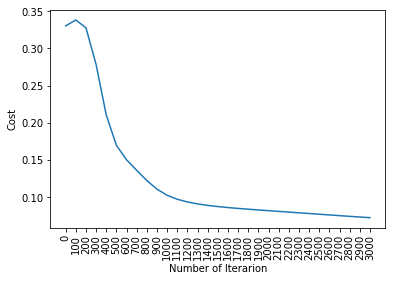

train accuracy: 95.95322357285737 %
test accuracy: 95.93846153846154 %


In [15]:
multi_layer_model([20,4],x_train,y_train,x_test,y_test,num_iter=3001,lr=0.03)

# the first array is where we desing our net for hidden layers. 
# for example layers_with_nodes=[4] means one hidden layer with 4 nodes, or layers_with_nodes=[10,5] means two hidden layers: first layer with 10 and second with 5 nodes

# lr is learning rate as usual

# num_iter is number of iterations that we want our model to train.

**CONCLUSION**

As we see above, it is actually not that hard to create a neural network that we can configure and go as deep as we want :) (or as wide as we want)

I hope you enjoyed my approach.

if you find it helpful, please leave a comment or like. So, I will contribute more :)

reference for inspiration: https://www.kaggle.com/kanncaa1/deep-learning-tutorial-for-beginners